# Feature extraction and reverse image search

This notebook will guide you through the procedure of analyzing a large set of images using a pre-trained convolutional network, extracting feature vectors for each one which represent each image. 

After the analysis is done, we will review some retrieval tasks that you can do with such an analysis. The main task will be that of "reverse image search," which refers to searching for the most similar set of images to some query image. 

For an introduction into feature extraction, see the previous notebook `feature_extraction.ipynb`.

### Prepare a dataset

You will need a folder of images to analyze. There is no limit to the size of the dataset, but for good results, at least 1000 would be good.

This notebook will use an example dataset called [Caltech-101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/), which contains roughly 9000 images in 101 categories. You may have already downloaded this dataset from the previous notebook, `7a_transfer_learning.ipynb`. If not, please download it from [here](http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz) and unzip it into the `data` folder, or just run the following commands in a terminal from the folder this notebook is in.

    wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
    tar -xvzf 101_ObjectCategories.tar.gz
    
You may use a custom folder of images (which may have subfolders) instead if you wish.

In [ ]:
#replace this with your custom dataset
!gdown --id 1-FKADwrZkk6-HS2GeO-rgysXEyXwK5lx
!unzip /content/5cats-256.zip

Downloading...
From: https://drive.google.com/uc?id=1-FKADwrZkk6-HS2GeO-rgysXEyXwK5lx
To: /content/5cats-256.zip
112MB [00:01, 99.9MB/s]


We'll start by importing the relevant Keras libraries that we'll be using.

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import os
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model

#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
#"/content/gdrive/My Drive/101_ObjectCategories/airplanes/image_0019.jpg"

Using TensorFlow backend.


In [ ]:
!echo "Downloading 101_Object_Categories for image notebooks"
!curl -L -o 101_ObjectCategories.tar.gz --progress-bar http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
!tar -xzf 101_ObjectCategories.tar.gz
!rm 101_ObjectCategories.tar.gz
!ls


 -=#=-#  #    #                                                               

gzip: stdin: not in gzip format
tar: Child returned status 1
tar: Error is not recoverable: exiting now
sample_data


We will load a previously-trained neural network, that of VGG16, which comes with Keras. If it's your first time loading it, it will automatically download the weights for you, which will take some time. Afterwards, the weights will be cached locally for future use. Keras has a number of other [pre-trained networs](https://keras.io/applications/) which you can try as well.

In [ ]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

553467904/553467096 [==============================] - 70s 0us/step


Let's look at the model summary to see how it's structured.

In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
#!ls 101_ObjectCategories
from google.colab import drive
drive.mount('/content/gdrive')

#!ls https://drive.google.com/drive/folders/17SWhZFl8rtV3J3jSyNZKTFIkCd1xm0HD?usp=sharing/
!ls 

Mounted at /content/gdrive
ls: cannot access '/drive.google.com/drive/my-drive': No such file or directory


In [ ]:
!ls ./gdrive/MyDrive/101_ObjectCategories

accordion	   cougar_body	    garfield	  menorah     snoopy
airplanes	   cougar_face	    gerenuk	  metronome   soccer_ball
anchor		   crab		    gramophone	  minaret     stapler
ant		   crocodile	    grand_piano   Motorbikes  starfish
BACKGROUND_Google  crocodile_head   hawksbill	  nautilus    stegosaurus
barrel		   cup		    headphone	  octopus     stop_sign
bass		   dalmatian	    hedgehog	  okapi       strawberry
beaver		   dollar_bill	    helicopter	  pagoda      sunflower
binocular	   dolphin	    ibis	  panda       tick
bonsai		   dragonfly	    inline_skate  pigeon      tmp
brain		   electric_guitar  joshua_tree   pizza       trilobite
brontosaurus	   elephant	    kangaroo	  platypus    umbrella
buddha		   emu		    ketch	  pyramid     watch
butterfly	   euphonium	    lamp	  revolver    water_lilly
camera		   ewer		    laptop	  rhino       wheelchair
cannon		   Faces	    Leopards	  rooster     wild_cat
car_side	   Faces_easy	    llama	  saxophone   windsor_chair
ceiling_fan	   ferry	  

The summary gives us a layer-by-layer description of the network. Notice that VGG16 is a deep network with 13 convolutional layers. It was previously trained on millions of images, and has over 100,000,000 weights and biases, the majority of which connect to the first fully-connected layer (fc1). VGG-16 is setup to take a fixed-size (224 x 224 x 3) RGB image at its input, and then forward it through a series of altrnating convolutional and max-pooling layers, then capped off by three fully-connected layers of 4096, 4096, and 1000 neurons, where the last layer is our softmax classification layer.

Notice that the output shape at each layer has `None` the first dimension. This is because the network can process multiple images in a single batch. So if you forward 5 images at shape [5, 224, 224, 3], then the output shape at each layer will be 5 in the first dimension.

### Forwarding an image through the network

In order to input an image into the network, it has to be pre-processed into a feature vector of the correct size. To help us do this, we will create a function `load_image(path)` which will handle the usual pre-processing steps: load an image from our file system and turn it into an input vector of the correct dimensions, those expected by VGG16, namely a color image of size 224x224.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def load_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

We'll load the image of the dog in the `data` directory, and take a look at its data vector.

image_0001.jpg	image_0017.jpg	image_0033.jpg	image_0049.jpg	image_0065.jpg
image_0002.jpg	image_0018.jpg	image_0034.jpg	image_0050.jpg	image_0066.jpg
image_0003.jpg	image_0019.jpg	image_0035.jpg	image_0051.jpg	image_0067.jpg
image_0004.jpg	image_0020.jpg	image_0036.jpg	image_0052.jpg	image_0068.jpg
image_0005.jpg	image_0021.jpg	image_0037.jpg	image_0053.jpg	image_0069.jpg
image_0006.jpg	image_0022.jpg	image_0038.jpg	image_0054.jpg	image_0070.jpg
image_0007.jpg	image_0023.jpg	image_0039.jpg	image_0055.jpg	image_0071.jpg
image_0008.jpg	image_0024.jpg	image_0040.jpg	image_0056.jpg	image_0072.jpg
image_0009.jpg	image_0025.jpg	image_0041.jpg	image_0057.jpg	image_0073.jpg
image_0010.jpg	image_0026.jpg	image_0042.jpg	image_0058.jpg	image_0074.jpg
image_0011.jpg	image_0027.jpg	image_0043.jpg	image_0059.jpg	image_0075.jpg
image_0012.jpg	image_0028.jpg	image_0044.jpg	image_0060.jpg	image_0076.jpg
image_0013.jpg	image_0029.jpg	image_0045.jpg	image_0061.jpg	image_0077.jpg
image_0014.jpg	image_0030

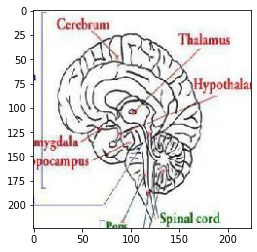

In [ ]:
!ls ./gdrive/MyDrive/101_ObjectCategories/brain
img, x = load_image("./gdrive/MyDrive/101_ObjectCategories/brain/image_0045.jpg")
print("shape of x: ", x.shape)
print("data type: ", x.dtype)
plt.imshow(img)

The shape of the image is [1, 224, 224, 3]. The reason it has the extra first dimension with 1 element is that the network can take batches of images to process them all simultaneously. So for example, 10 images can be propagated through the network if `x` has a shape of [10, 224, 224, 3].

Let's get class predictions from this model. We forward `x` through `model` and then use the built-in `decode_predictions` to look up the class names.

In [ ]:
# forward the image through the network
predictions = model.predict(x)

# print out the 
for _, pred, prob in decode_predictions(predictions)[0]:
    print("predicted %s with probability %0.3f" % (pred, prob))


40960/35363 [==================================] - 0s 0us/step
predicted envelope with probability 0.656
predicted web_site with probability 0.211
predicted menu with probability 0.033
predicted binder with probability 0.016
predicted handkerchief with probability 0.010


### Feature extraction

What we have in the `model` variable is a highly effective image classifier trained on the ImageNet database. We expect that the classifier must form a very effective representation of the image in order to be able to classify it with such high accuracy. We can use this to our advantage by re-purposing this for another task.

What we do is we copy the model, but remove the last layer (the classification layer), so that the final layer of the new network, called `feat_extractor` is the second 4096-neuron fully-connected layer, "fc2 (Dense)".

The way we do this is by instantiating a new model called `feature_extractor` which takes a reference to the desired input and output layers in our VGG16 model. Thus, `feature_extractor`'s output is the layer just before the classification, the last 4096-neuron fully connected layer. It looks like a copy, but internally, all Keras is doing is making a pointer to each of these layers and not actually copying anything. Thus, the output "prediction" from `feat_extractor` will just be the layer `fc2` from `model`.

If we run the `summary()` function again, we see that the architecture of `feat_extractor` is identical to the original `model`, except the last layer has been removed. We also know that not just the architecture is the same, but the two have the same weights as well.

In [ ]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

Now let's see the feature extractor in action. We pass the same image from before into it, and look at the results. The `predict` function returns an array with one element per image (in our case, there is just one). Each element contains a 4096-element array, which is the activations of the last fully-connected layer `fc2` in VGG16. Let's plot the array as well.

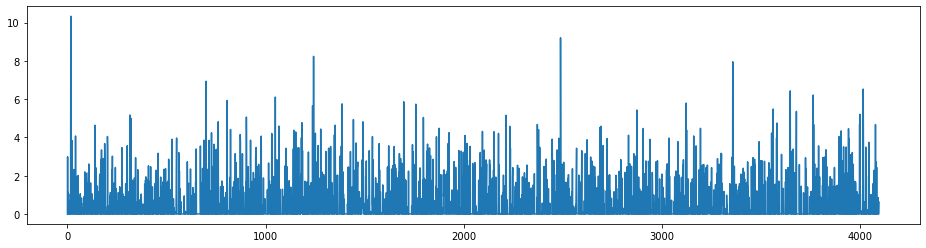

In [ ]:
#img, x = load_image("/content/5cats-256/10005498_1418888668364064_1838381838_n.jpg")
img, x = load_image("./gdrive/MyDrive/101_ObjectCategories/brain/image_0045.jpg")
feat = feat_extractor.predict(x)

plt.figure(figsize=(16,4))
plt.plot(feat[0])

Our expectation is that the `fc2` activations form a very good representation of the image, such that similar images should produce similar activations. In other words, the `fc2` activations of two images which have similar content should be very close to each other. We can exploit this to do information retrieval. 

In the next cell, we will open a folder of images for analysis. First, the next cell will just recursively crawl the folder specified by `image_path` looking for images of the extensions inside of `image_extensions` and then limiting them to a random subset of maximum `max_num_images` images. Change these variables if you wish to change the target images.

In [ ]:
#images_path = '/content/5cats-256'
images_path = './gdrive/MyDrive/101_ObjectCategories'
image_extensions = ['.jpg', '.png', '.jpeg']   # case-insensitive (upper/lower doesn't matter)
max_num_images = 10000

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(xrange(len(images)), max_num_images))]

print("keeping %d images to analyze" % len(images))

keeping 936 images to analyze


In the next cell, we will begin a loop which will open each image, extract its feature vector, and append it to a list called `features` which will contain our activations for each image. This process may take a long time depending on your graphics card, so you may need to leave it running for as much as a few hours. On a good graphics card, this process may only take a half hour or so. Every 1000 images, you will receive a notification print-out.

In [ ]:
import time
tic = time.clock()


features = []
for i, image_path in enumerate(images):
    if i % 500 == 0:
        toc = time.clock()
        elap = toc-tic;
        print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(images),elap))
        tic = time.clock()
    img, x = load_image(image_path);
    feat = feat_extractor.predict(x)[0]
    features.append(feat)

print('finished extracting features for %d images' % len(images))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


analyzing image 0 / 936. Time: 0.0008 seconds.
analyzing image 500 / 936. Time: 8.7261 seconds.
finished extracting features for 936 images


Alone, these activations provide a good representation, but it is a good idea to do one more step before using these as our feature vectors, which is to do a [principal component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) to reduce the dimensionality of our feature vectors down to 300. We apply PCA for two reasons: 1) the 4096-bit feature vector may have some redundancy in it, such that multiple elements in the vector are highly correlated or similar. This would skew similarity comparisons towards those over-represented features. 2) Operating over 4096 elements is inefficient both in terms of space/memory requirements and processor speed, and it would be better for us if we can reduce the length of these vectors but maintain the same effective representation. PCA allows us to do this by reducing the dimensionality down of the feature vectors from 4096 to much less, but maintain a representation which is still faithful to the original data, by preserving the relative inter-point distance.

Thus, PCA reduces the amount of redundancy in our features (from duplicate or highly-correlated features), speeds up computation over them, and reduces the amount of memory they take up.

The next cell will instantiate a `PCA` object, which we will then fit our data to, choosing to keep the top 300 principal components. This may take a few minutes.

In [ ]:
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)

PCA(n_components=300)

The `pca` object stores the actual transformation matrix which was fit in the previous cell. We can now use it to transform any original feature vector (of length 4096) into a reduced 300-dimensional feature vector in the principal component space found by the PCA. 

So we take our original feature vectors, and transform them to the new space.

In [ ]:
pca_features = pca.transform(features)

We are now ready to do our reverse image queries! The matrix `pca_features` contains a compact representation of our images, one 300-element row for each image with high-level feature detections. We should expect that two similar images, which have similar content in them, should have similar arrays in `pca_features`.

Let's pick a random query image.

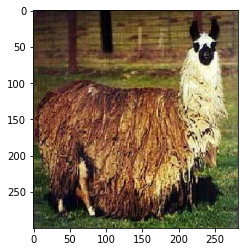

In [ ]:
import random

# grab a random query image
query_image_idx = int(len(images) * random.random())

# let's display the image
img = image.load_img(images[query_image_idx])
plt.imshow(img)

The assumption we can now make is that two images which have similar content, should produce similar feature vectors. The next two cells will randomly select one image, and then compute a measurement of the dissimilarity (or distance) of that image's PCA feature vector to every other image's feature vector. The dissimilarity metric we use is [cosine distance](https://en.wikipedia.org/wiki/Cosine_similarity). 

In [ ]:
from scipy.spatial import distance

similar_idx = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]

The list `similar_idx` contains the image's similarity to every other one. We can sort that list and find the indexes of the most similar images. The next cell will sort them, and then find the most similar items, and return the indexes 5 most similar images. Notice we take from indexes 1:6 rather than 0:5 because the most similar image to the query image, will trivially be the query image itself, since it is included in the distance calculation. So we just skip it.

In [ ]:
idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[1:6]

The next cell opens the images specified by `idx_closest` and concatenates them into a single image (resizing each so it has a height of 100 pixels.

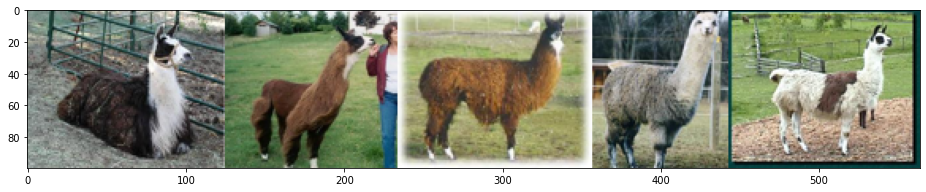

In [ ]:
# load all the similarity results as thumbnails of height 100
thumbs = []
for idx in idx_closest:
    img = image.load_img(images[idx])
    img = img.resize((int(img.width * 100 / img.height), 100))
    thumbs.append(img)

# concatenate the images into a single image
concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)

# show the image
plt.figure(figsize = (16,12))
plt.imshow(concat_image)


For convenience, we'll automate this process by defining the function `get_closest_images`, which will compute the cosine distance between the PCA features of `query_image_idx`-th image in our dataset, and the PCA features of every image in the dataset (including itself, trivially 0). It then returns an array of indices to the `num_results` (default is 5) most similar images to it (not including itself). 

We also define a helper function `get_concatenated_images` which will simply take those resulting images and concatenate them into a single image for easy display.

In [ ]:
def get_closest_images(query_image_idx, num_results=5):
    distances = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image


So now we can do our lookups like this:

Text(0.5, 1.0, 'result images')

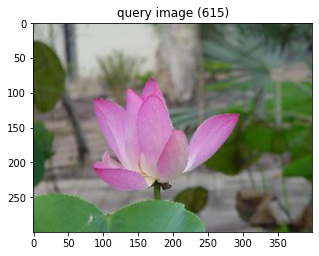

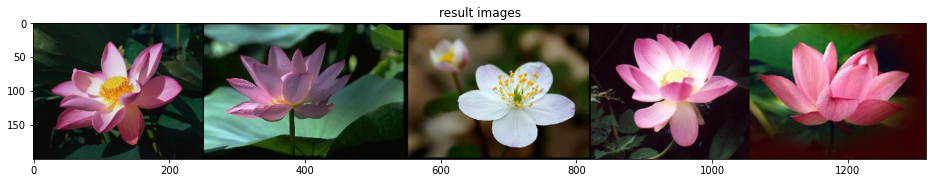

In [ ]:
# do a query on a random image
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

# display the query image
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title("query image (%d)" % query_image_idx)

# display the resulting images
plt.figure(figsize = (16,12))
plt.imshow(results_image)
plt.title("result images")

And again...

Text(0.5, 1.0, 'result images')

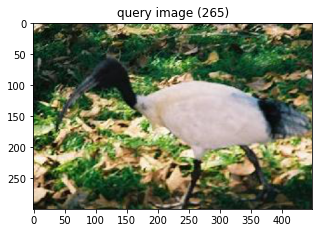

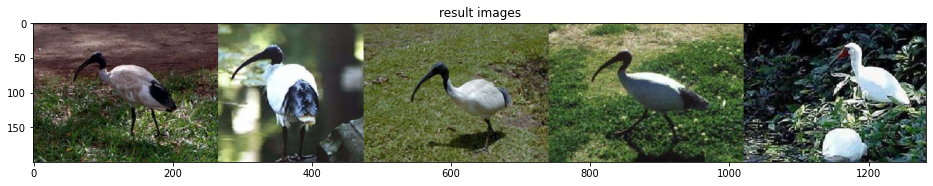

In [ ]:
# do a query on a random image
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

# display the query image
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title("query image (%d)" % query_image_idx)

# display the resulting images
plt.figure(figsize = (16,12))
plt.imshow(results_image)
plt.title("result images")

## Importing new images

What if you load a new image which was not previously in the analysis?  For that, we can simply run it through the same process by extracting its feature vector, and projecting it into our PCA space using the saved pca object. So for example...

Mounted at /content/gdrive


Text(0.5,1,'result images')

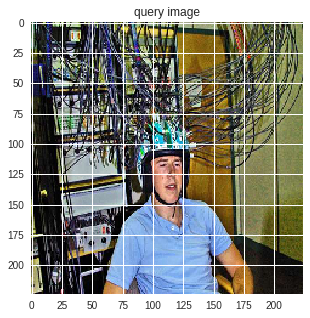

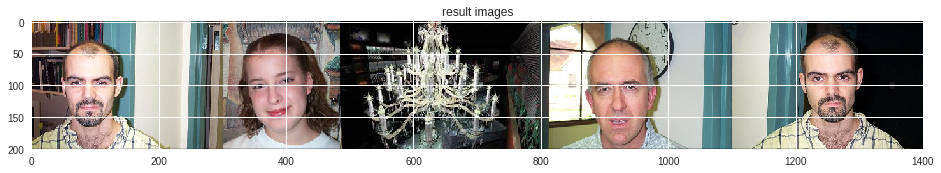

In [ ]:

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# load image and extract features
new_image, x = load_image("/content/gdrive/My Drive/newequipment.jpg")
new_features = feat_extractor.predict(x)

# project it into pca space
new_pca_features = pca.transform(new_features)[0]

# calculate its distance to all the other images pca feature vectors
distances = [ distance.cosine(new_pca_features, feat) for feat in pca_features ]
idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[0:5]  # grab first 5
results_image = get_concatenated_images(idx_closest, 200)

# display the results
plt.figure(figsize = (5,5))
plt.imshow(new_image)
plt.title("query image")

# display the resulting images
plt.figure(figsize = (16,12))
plt.imshow(results_image)
plt.title("result images")

Thus we can see the usefulness of feature vectors for tasks other than classification. Besides for similarity retrieval, these feature vectors can be broadly useful for other things. If we are satisfied with the quality of our image vectors, now would be a good time to save them to disk for later usage. You will need these vectors to run the [next notebook on making an image t-SNE](image-tsne.ipynb).

We need to save both the image features matrix (the PCA-reduced features, not the originals), as well as the array containing the paths to each image, to make sure we can line up the images to their corresponding vectors. It is also best to save `pca` itself so we can project new images into the space if we wish. We can save everything to disk using `pickle`.

In [ ]:
import pickle

pickle.dump([images, pca_features, pca], open('/content/features_5cats.p', 'wb'))